In [8]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Simulation parameters
N = 100  # Number of birds
L = 10  # Size of box
R = 3  # Range for observing other birds
r = 1  # Minimum distance to other birds
v_max = 5  # Maximum velocity
lambda_c = 5
lambda_a = 2
lambda_m = 2
dt = 0.2  # Time step
Nt = 80  # Number of time steps
v0 = 0.5      # velocity
Rsq = R**2
eta = 0.01

def initialize_birds(N,L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # bird positions
    x = np.random.rand(N,1)*L
    y = np.random.rand(N,1)*L

    # bird velocities
    theta = 2 * np.pi * np.random.rand(N,1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

def apply_boundary_conditions(x,y,L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

def update_positions(x,y,xv,vy,dt,L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += xv*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y

# Initial positions, velocities, and directions
x, y, vx, vy, theta = initialize_birds(N, L)

# Function to find neighbors within range R
def get_local_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < R and i != j}

# Function to find birds that are too close (within distance r)
def get_too_close_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < r and i != j}

# Function to limit speed
def limit_speed(vx, vy, v_max):
    speed = np.linalg.norm([vx, vy])
    if speed > v_max:
        vx = (v_max / speed) * vx
        vy = (v_max / speed) * vy
    return vx, vy


def get_mean_theta(x, y, theta, Rsq):
    mean_theta = np.zeros_like(theta)  # Initialize with zeros
    for bird in range(len(theta)):
        neighbors = (x - x[bird])**2 + (y - y[bird])**2 < Rsq
        if np.any(neighbors):
            angles = theta[neighbors.flatten()]
            mean_theta[bird] = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))
    return mean_theta


# Define drone parameters
N_drones = 2
v_d = v_max
x_drones = np.random.rand(N_drones, 2) * L
v_drones = np.array([[v_d, 0.0] for _ in range(N_drones)])  # Assuming drones move only in the x-direction
R_drone = 1.0  # Detection radius for drones
lambda_d = 1

def update_velocities(x, y, vx_i, vy_i, i):
    local_birds = get_local_birds(x, y, i)
    too_close_birds = get_too_close_birds(x, y, i)

    v_c = lambda_c * (
        (np.sum([x[j] for j in local_birds]) / len(local_birds) - x[i]) if len(local_birds) > 0 else 0,
        (np.sum([y[j] for j in local_birds]) / len(local_birds) - y[i]) if len(local_birds) > 0 else 0
    )

    v_a = lambda_a * (
        (np.sum([x[i] - x[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0),
        (np.sum([y[i] - y[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0)
    )

    v_m = lambda_m * (
        (np.sum([vx[j] for j in local_birds]) / len(local_birds) - vx_i) if len(local_birds) > 0 else 0,
        (np.sum([vy[j] for j in local_birds]) / len(local_birds) - vy_i) if len(local_birds) > 0 else 0
    )

    # Calculate the direction from each drone to the COM of birds
    drone_directions = lambda_d * np.array([
        np.sum([(x[i] - x_d[j]) / np.linalg.norm([x[i] - x_d[j], y[i] - y_d[j]])**2 for j in range(N_drones)]),
        np.sum([(y[i] - y_d[j]) / np.linalg.norm([x[i] - x_d[j], y[i] - y_d[j]])**2 for j in range(N_drones)])
    ])

    vx_i, vy_i = vx_i + v_c[0] + v_a[0] + v_m[0] + drone_directions[0], vy_i + v_c[1] + v_a[1] + v_m[1] + drone_directions[1]

    # Limit speed
    vx_i, vy_i = limit_speed(vx_i, vy_i, v_max)

    return vx_i, vy_i




def update_theta(x, y, theta, Rsq, eta, N):
    mean_theta = get_mean_theta(x, y, theta, Rsq)
    theta = mean_theta + eta * (np.random.rand(N) - 0.5)
    return theta

def step(x, y, vx, vy, theta, Rsq, eta, N, dt, L):
    for i in range(N):
        x, y = update_positions(x, y, vx, vy, dt, L)
        theta = update_theta(x, y, theta, Rsq, eta, N)
        vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i)
        vx[i], vy[i] = limit_speed(vx[i], vy[i], v_max)
    return x, y, vx, vy, theta



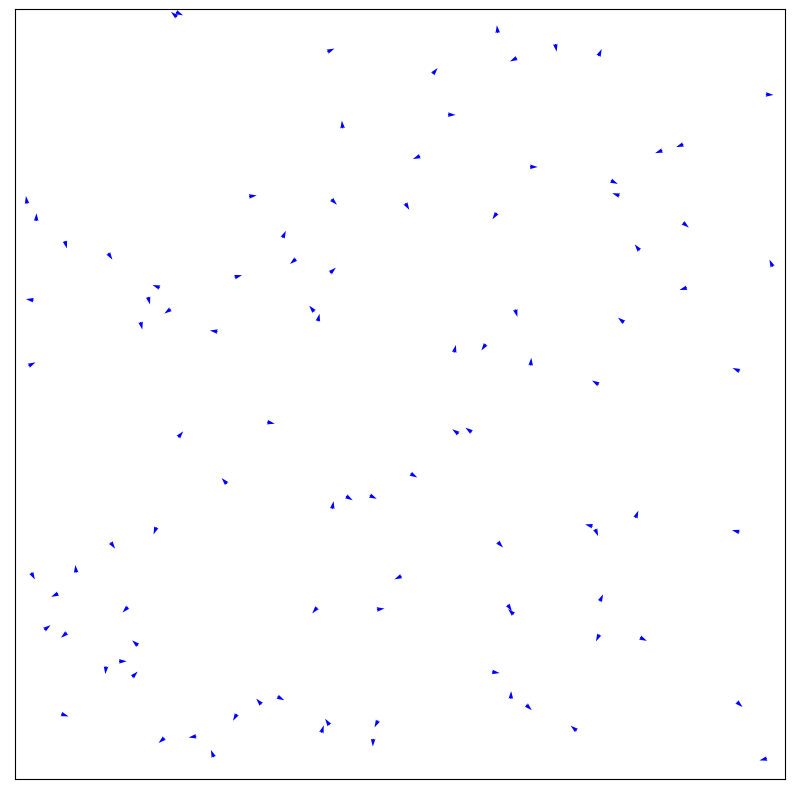

NameError: name 'x_d' is not defined

In [9]:
# Function to visualize the flock
def visualize(ax, x, y, vx, vy):
    ax.clear()
    q = ax.quiver(x, y, vx, vy, scale=50, color='blue', width=0.007)
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.pause(0.001)
    clear_output(wait=True)
    display(fig)

# set up a figure
fig, ax = plt.subplots(figsize=(10, 10))

# get the initial configuration
x, y, vx, vy, theta = initialize_birds(N, L)

# do an initial plot and set up the axes
visualize(ax, x, y, vx, vy)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x, y, vx, vy, theta = step(x, y, vx, vy, theta, Rsq, v0 * eta, N, dt, L)
    visualize(ax, x, y, vx, vy)




In [6]:
def visualize(ax, x, y, vx, vy):
    ax.clear()

    # Normalize the velocity vectors
    norm = np.sqrt(vx**2 + vy**2)
    vx_normalized = vx / norm
    vy_normalized = vy / norm

    # Plot the arrows with fixed length (scale=1)
    q = ax.quiver(x, y, vx_normalized, vy_normalized, scale=50, color='blue', width=0.007)
    
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.pause(0.0001)
    clear_output(wait=True)
    display(fig)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x, y, vx, vy, theta = step(x, y, vx, vy, theta, Rsq, v0 * eta, N, dt, L)
    visualize(ax, x, y, vx, vy)


NameError: name 'x_d' is not defined

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Simulation parameters
N = 100  # Number of birds
L = 10  # Size of box
R = 3  # Range for observing other birds
r = 1  # Minimum distance to other birds
v_max = 5  # Maximum velocity
lambda_c = 5
lambda_a = 2
lambda_m = 2
dt = 0.2  # Time step
Nt = 80  # Number of time steps
v0 = 0.5  # velocity
Rsq = R**2
eta = 0.01

def initialize_birds(N, L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # bird positions
    x = np.random.rand(N, 1) * L
    y = np.random.rand(N, 1) * L

    # bird velocities
    theta = 2 * np.pi * np.random.rand(N, 1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

def initialize_drones(N, L):
    '''
    Set initial positions and velocities for drones
    '''
    # drone positions
    x = np.random.rand(N, 1) * L
    y = np.random.rand(N, 1) * L

    # drone velocities
    vx = np.zeros((N, 1))
    vy = np.zeros((N, 1))

    return x, y, vx, vy

def apply_boundary_conditions(x, y, L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

def update_positions(x, y, xv, vy, dt, L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += xv * dt
    y += vy * dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x, y, L)
    return x, y

# Initial positions, velocities, and directions
x, y, vx, vy, theta = initialize_birds(N, L)

# Function to find neighbors within range R
def get_local_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < R and i != j}

# Function to find birds that are too close (within distance r)
def get_too_close_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < r and i != j}

# Function to limit speed
def limit_speed(vx, vy, v_max):
    speed = np.linalg.norm([vx, vy])
    if speed > v_max:
        vx = (v_max / speed) * vx
        vy = (v_max / speed) * vy
    return vx, vy

def get_mean_theta(x, y, theta, Rsq):
    mean_theta = np.zeros_like(theta)  # Initialize with zeros
    for bird in range(len(theta)):
        neighbors = (x - x[bird])**2 + (y - y[bird])**2 < Rsq
        if np.any(neighbors):
            angles = theta[neighbors.flatten()]
            mean_theta[bird] = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))
    return mean_theta

# Define drone parameters
N_drones = 2
v_d = v_max
x_drones = np.random.rand(N_drones, 2) * L
v_drones = np.array([[v_d, 0.0] for _ in range(N_drones)])  # Assuming drones move only in the x-direction
R_drone = 1.0  # Detection radius for drones
lambda_d = 1

def update_velocities(x, y, vx_i, vy_i, i, x_drones, y_drones, R_drone):
    local_birds = get_local_birds(x, y, i)
    too_close_birds = get_too_close_birds(x, y, i)

    v_c = lambda_c * (
        (np.sum([x[j] for j in local_birds]) / len(local_birds) - x[i]) if len(local_birds) > 0 else 0,
        (np.sum([y[j] for j in local_birds]) / len(local_birds) - y[i]) if len(local_birds) > 0 else 0
    )

    v_a = lambda_a * (
        (np.sum([x[i] - x[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0),
        (np.sum([y[i] - y[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0)
    )

    v_m = lambda_m * (
        (np.sum([vx[j] for j in local_birds]) / len(local_birds) - vx_i) if len(local_birds) > 0 else 0,
        (np.sum([vy[j] for j in local_birds]) / len(local_birds) - vy_i) if len(local_birds) > 0 else 0
    )

    drone_directions = lambda_d * np.array([
        np.sum([(x[i] - x_drones[j, 0]) / np.linalg.norm([x[i] - x_drones[j, 0], y[i] - y_drones[j, 0]])**2 for j in range(N_drones)]),
        np.sum([(y[i] - y_drones[j, 0]) / np.linalg.norm([x[i] - x_drones[j, 0], y[i] - y_drones[j, 0]])**2 for j in range(N_drones)])
    ])

    # Check if the bird is within the observation range of any drone
    for d in range(N_drones):
        distance_to_drone = np.linalg.norm([x[i] - x_drones[d, 0], y[i] - y_drones[d, 0]])
        if distance_to_drone < R_drone:
            # Birds within R_drone experience a negative velocity
            vx_i, vy_i = -vx_i, -vy_i
            break

    vx_i, vy_i = vx_i + v_c[0] + v_a[0] + v_m[0] + drone_directions[0], vy_i


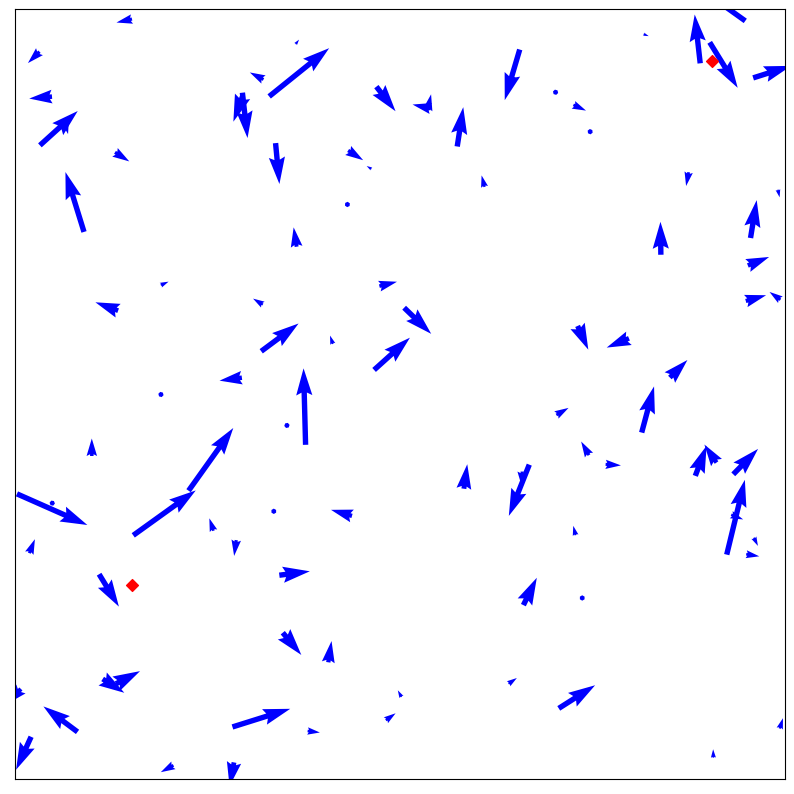

KeyboardInterrupt: 

In [25]:
# Function to visualize the flock
def visualize(ax, x, y, vx, vy, x_drones, v_drones):
    ax.clear()
    q = ax.quiver(x, y, vx, vy, scale=50, color='blue', width=0.007)
    ax.scatter(x_drones[:, 0], x_drones[:, 1], color='red', marker='D')  # Plot drones in red
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.pause(0.001)
    clear_output(wait=True)
    display(fig)


# set up a figure
fig, ax = plt.subplots(figsize=(10, 10))

# get the initial configuration
x, y, vx, vy, theta = initialize_birds(N, L)

# do an initial plot and set up the axes
visualize(ax, x, y, vx, vy, x_drones, v_drones)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x, y, vx, vy, theta, x_drones, v_drones = step(x, y, vx, vy, theta, Rsq, v0 * eta, N, dt, L, x_drones, v_drones, R)
    visualize(ax, x, y, vx, vy, x_drones, v_drones)

In [36]:
# Function to update quiver plot data
def update_quiver(quiver, x, y, vx, vy):
    quiver.set_UVC(vx, vy)
    quiver.set_offsets(np.column_stack([x, y]))
    return quiver

# Function to update scatter plot data for drones
def update_drones(scatter, x, y):
    scatter.set_offsets(np.column_stack([x, y]))
    return scatter

def update_birds(x, y, vx, vy, theta, R, eta, N, dt, x_drones, y_drones):
    for i in range(N):
        vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, x_drones, y_drones, R_drone)
        vx[i], vy[i] = limit_speed(vx[i], vy[i], v_max)

    return vx, vy


# Assuming initialization of birds and drones
x_birds, y_birds, vx_birds, vy_birds, theta_birds = initialize_birds(N, L)
x_drones, y_drones, vx_drones, vy_drones = initialize_drones(N_drones, L)

# Assuming initialization of other required variables
Rsq = R**2  # If Rsq is not already defined

# Assuming initialization of quiver and scatter plots
birds_quiver = ax.quiver(x_birds, y_birds, vx_birds, vy_birds, scale=50, color='blue', width=0.007)
drones_scatter = ax.scatter([], [], color='red', marker='D')

# do each step, updating the quiver and scatter plots
for iT in range(Nt):
    x_birds, y_birds, vx_birds, vy_birds, theta_birds, x_drones, v_drones = step(x_birds, y_birds, vx_birds, vy_birds, theta_birds, Rsq, v0 * eta, N, dt, L, x_drones, v_drones, R_drone)

    # Update positions
    x_birds, y_birds = update_positions(x_birds, y_birds, vx_birds, vy_birds, dt, L)

    # Update drones
    update_positions(drones_scatter, x_drones, y_drones)

    # Update birds
    vx_birds, vy_birds = update_birds(x_birds, y_birds, vx_birds, vy_birds, theta_birds, R, eta, N, dt, x_drones, y_drones)

    # Update bird velocities
    theta_birds = update_theta(x_birds, y_birds, theta_birds, Rsq, eta, N)

    # Update quiver plot data for birds
    update_quiver(birds_quiver, x_birds, y_birds, vx_birds, vy_birds)

    # Slight delay for visualization
    plt.pause(0.1)

    # Clear the previous plot
    clear_output(wait=True)

    # Display the new plot
    display(fig)

# Ensure the final plot stays visible
plt.show()


TypeError: cannot unpack non-iterable NoneType object